# Goal and data summary
We are gaven 5 years store-item sales data to predict 3 months sales data. 

The evaluation metircs is SMAPE(symmetric mean absolute percentage error). 

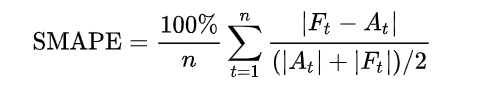

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import os

There are 913000 entries with 4 cloumns in the train set and 45000 entries with 3 cloumns in the test set. 

In [ ]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

In [ ]:
train.info()

In [ ]:
test.head()

In [ ]:
test.info()

In [ ]:
train_eda=train.copy()
train_eda.index=pd.to_datetime(train_eda['date'])
train_eda.drop('date',axis=1,inplace=True)
train_eda['year']=train_eda.index.year-min(train_eda.index.year)+1
train_eda['month']=train_eda.index.month
train_eda['weekday']=train_eda.index.weekday
train_eda.sample(5)

Plot the item sales and store sales trends by the year. The two plots show the similar growth pattern by the year.

In [ ]:
agg_year_item = pd.pivot_table(train_eda, index='year', columns='item',values='sales', aggfunc=np.mean).values
agg_year_store=pd.pivot_table(train_eda,index='year',columns='store',values='sales',aggfunc=np.mean).values

In [ ]:
import matplotlib.pyplot as plt
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title('item sales trend with the year')
plt.xlabel('year')
plt.ylabel('item sales')
plt.show()

plt.plot(agg_year_store/agg_year_store.mean(0)[np.newaxis])
plt.title('store sales trend with the year')
plt.xlabel('year')
plt.ylabel('store sales')
plt.show()

Choose two defferent items from 2 stores to decomposite the seasonality, trend and residue.

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

df_7_9=train_eda[(train_eda['store']==7) & (train_eda['item']==9)]['sales'].resample('MS').sum()
decomposition = sm.tsa.seasonal_decompose(df_7_9, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
rcParams['figure.figsize'] = 18, 8
df_10_5=train_eda[(train_eda['store']==10) & (train_eda['item']==5)]['sales'].resample('MS').sum()
decomposition = sm.tsa.seasonal_decompose(df_10_5, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
#define the smape function
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

# Apply the simplest model

In [ ]:
#this algorithm is borrowed from this kernel https://www.kaggle.com/sgorlick/4th-place-sol-n

#concatenate train and test
cols=list(train.columns)
x = pd.concat([train,test],axis=0).reset_index(drop=True)
x = x.loc[:,cols]
x.sample()

In [ ]:
#index to timestamp, add year number, month and weekday as new features
x.index=pd.to_datetime(x.date)
x.drop('date',axis=1,inplace=True)

x['year'] =  x.index.year - min(x.index.year) + 1
x['month'] = x.index.month
x['weekday'] = x.index.weekday

In [ ]:
#create month_mod among the whole train set
month_smry= (
        ( x.groupby(['month']).agg([np.nanmean]).sales - np.nanmean(x.sales) ) / np.nanmean(x.sales)
).rename(columns={'nanmean':'month_mod'})
x=x.join(month_smry,how='left',on='month')

In [ ]:
#create year_mod among the whole train set
year_smry= (
        ( x.groupby(['year']).agg([np.nanmean]).sales - np.nanmean(x.sales) ) / np.nanmean(x.sales)
).rename(columns={'nanmean':'year_mod'})


In [ ]:
#calculate CAGR(compund annully growth rate) from the 2nd year to the 5th yar. 
CAGR = (x[x.year==5].groupby(['store','item']).agg(np.nanmean).sales /
        x[x.year==2].groupby(['store','item']).agg(np.nanmean).sales )**(1/4)-1
print((np.mean(CAGR),np.std(CAGR)))

In [ ]:
#fill year_mod field for the test year by the following calculation  
year_smry.loc[6,:] =  np.mean(CAGR)*3
x=x.join(year_smry,how='left',on='year')

In [ ]:
#create the weeday_mod
weekday_smry= (
        ( x.groupby(['weekday']).agg([np.nanmean]).sales - np.nanmean(x.sales) ) / np.nanmean(x.sales)
).rename(columns={'nanmean':'weekday_mod'})
x=x.join(weekday_smry,how='left',on='weekday')

In [ ]:
#create store_item_mod
store_item_smry= (
        ( x.groupby(['store','item']).agg([np.nanmean]).sales - np.nanmean(x.sales) ) / np.nanmean(x.sales)
).rename(columns={'nanmean':'store_item_mod'})
x=x.join(store_item_smry,how='left',on=['store','item'])

In [ ]:
#predict the sales by the following way,the sampe is not bad for the whole data,
#the sampe for 1-3 month sales data is slightly worse.
x['smry_product']=np.product(x.loc[:,['month_mod','year_mod','weekday_mod','store_item_mod',]]+1,axis=1)
x['sales_mod_pred']=np.round(x.smry_product*np.round(np.nanmean(x.sales),1))
print(smape(x.sales,x.sales_mod_pred))
print(smape(x.sales[x.month < 4],x.sales_mod_pred[x.month < 4]))


In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(x.sales,x.sales_mod_pred,s=2)
plt.axis('equal')
plt.show()
plt.savefig('graph.png')

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(x.sales[x.month < 4],x.sales_mod_pred[x.month < 4],s=2)
plt.axis('equal')
plt.show()
plt.savefig('graph.png')


In [ ]:
# submission
sample=pd.DataFrame()
sample['sales'] = x[x.year==6].sales_mod_pred.reset_index(drop=True)
sample['id']=test['id']
sample.to_csv('submittal.csv', index= False)